In [1]:
import os
import sys

# Check if the notebook is running on Google Colab
if 'google.colab' in sys.modules:
    # Clone the repository
    # os.system('git clone https://github.com/orabe/gait_modulation.git')
    # Change directory to the cloned repository
    # os.chdir('gait_modulation')
    
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Change directory to the desired location in Google Drive
    os.chdir('/content/drive/MyDrive/master_thesis/gait_modulation')

In [2]:
if 'google.colab' in sys.modules:    
    # Install the package
    # os.system('pip install gait_modulation')
    
    # Install the package in editable mode
    os.system('pip install -e .')

In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import LeaveOneGroupOut, cross_val_predict
from sklearn.model_selection import learning_curve

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import time
import logging
import seaborn as sns

from gait_modulation import FeatureExtractor2
from gait_modulation import LSTMClassifier
from gait_modulation.utils.utils import load_pkl, initialize_tf, disable_xla

In [4]:
# Load the preprocessed data
patient_epochs_path = os.path.join("results", "pickles", "patients_epochs.pickle")
subjects_event_idx_dict_path = os.path.join("results", "pickles", "subjects_event_idx_dict.pickle")

patient_epochs = load_pkl(patient_epochs_path)
subjects_event_idx_dict = load_pkl(subjects_event_idx_dict_path)

patient_names = np.array(list(patient_epochs.keys()))
print(f"Loaded data for {len(patient_names)} patients.")

# Slice patients for testing
patient_names = patient_names[:4]
patient_epochs = {k: patient_epochs[k] for k in patient_names}
subjects_event_idx_dict = {k: subjects_event_idx_dict[k] for k in patient_names}
print(f"Loaded data for {len(patient_names)} patients.")

Loaded data for 7 patients.
Loaded data for 4 patients.


In [5]:
# Load the best model
ts = "20250322-043928"
model_dir = os.path.join("logs", "lstm", "models", f"run_{ts}")
    
best_model_path = os.path.join(model_dir, "best_lstm_model.h5")
# keras_model_path = os.path.join(model_dir, 'best_lstm_model.keras')

custom_objects = {
    'masked_loss_binary_crossentropy': LSTMClassifier.masked_loss_binary_crossentropy,
}
best_model = load_model(best_model_path, custom_objects=custom_objects)

# Load the padded data
padded_data_path = os.path.join("results", "padded_data.npz")
with np.load(padded_data_path) as data:
    X_padded = data['X_padded']
    y_padded = data['y_padded']
    groups = data['groups']

mask_vals = (0.0, 2)

In [6]:
# Initialize Leave-One-Group-Out cross-validator
logo = LeaveOneGroupOut()
n_splits = logo.get_n_splits(X_padded, y_padded, groups)
print(f"Number of splits: {n_splits}")

# Initialize arrays to store predictions and true labels
y_true_all = np.empty((0, y_padded.shape[1]))
y_pred_all = np.empty((0, y_padded.shape[1]))

# Initialize lists to store metrics for each fold
accuracy_list = []
f1_list = []
precision_list = []
recall_list = []
roc_auc_list = []

# Evaluate per patient (group)
per_fold_metrics = []
for fold, (train_idx, test_idx) in enumerate(logo.split(X_padded, y_padded, groups)):
    print("=" * 60)
    print(f"\n---- Fold {fold + 1}/{n_splits} | Patient {groups[test_idx[0]]}] ----\n")

    # Get the test data
    X_test = X_padded[test_idx]
    y_test = y_padded[test_idx]

    # Make predictions on the test data
    y_pred = best_model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)

    # Evaluate the model for the current fold
    f1 = LSTMClassifier.masked_f1_score(y_test, y_pred)
    acc = LSTMClassifier.masked_accuracy_score(y_test, y_pred)
    precision = LSTMClassifier.masked_precision_score(y_test, y_pred)
    recall = LSTMClassifier.masked_recall_score(y_test, y_pred)
    roc_auc = LSTMClassifier.masked_roc_auc_score(y_test, y_pred)
    confusion_matrix = LSTMClassifier.masked_confusion_matrix(y_test, y_pred)
    classification_report = LSTMClassifier.masked_classification_report(y_test, y_pred, target_names=['Normal Walking', 'Modulation'])

    per_fold_metrics.append({
        "patient": groups[test_idx[0]],
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "roc_auc": roc_auc,
        "confusion_matrix": confusion_matrix,
        "classification_report": classification_report
    })

    # Store metrics for each fold
    accuracy_list.append(acc)
    f1_list.append(f1)
    precision_list.append(precision)
    recall_list.append(recall)
    roc_auc_list.append(roc_auc)

    print(f"Accuracy = {acc:.4f}, F1-score = {f1:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, ROC AUC = {roc_auc:.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix}")
    print(f"Classification Report:\n{classification_report}")

    # Store the true labels and predictions
    y_true_all = np.vstack([y_true_all, y_test])
    y_pred_all = np.vstack([y_pred_all, y_pred])

# Overall evaluation
# Remove padding values from the aggregated true labels and predictions
y_true_masked = y_true_all[y_true_all != mask_vals[1]]
y_pred_masked = y_pred_all[y_true_all != mask_vals[1]]

# Calculate overall metrics using the aggregated and masked true labels and predictions
overall_accuracy = LSTMClassifier.masked_accuracy_score(y_true_masked, y_pred_masked)
overall_f1 = LSTMClassifier.masked_f1_score(y_true_masked, y_pred_masked)
overall_precision = LSTMClassifier.masked_precision_score(y_true_masked, y_pred_masked)
overall_recall = LSTMClassifier.masked_recall_score(y_true_masked, y_pred_masked)
overall_roc_auc = LSTMClassifier.masked_roc_auc_score(y_true_masked, y_pred_masked)
overall_confusion_matrix = LSTMClassifier.masked_confusion_matrix(y_true_masked, y_pred_masked)
overall_classification_report = LSTMClassifier.masked_classification_report(y_true_masked, y_pred_masked, target_names=['Normal Walking', 'Modulation'])

# Print overall metrics
print("*" * 60)
print(f"\nOverall Accuracy: {overall_accuracy:.4f}, Overall F1 Score: {overall_f1:.4f}, , Overall Precision: {overall_precision:.4f}, Overall Recall: {overall_recall:.4f} Overall ROC AUC: {overall_roc_auc:.4f}")
print(f"Overall Confusion Matrix:\n{overall_confusion_matrix}")
print(f"Overall Classification Report:\n{overall_classification_report}")

# Calculate mean and standard deviation of metrics across folds
mean_accuracy = np.mean(accuracy_list)
std_accuracy = np.std(accuracy_list)
mean_f1 = np.mean(f1_list)
std_f1 = np.std(f1_list)
mean_precision = np.mean(precision_list)
std_precision = np.std(precision_list)
mean_recall = np.mean(recall_list)
std_recall = np.std(recall_list)
mean_roc_auc = np.mean(roc_auc_list)
std_roc_auc = np.std(roc_auc_list)

# Print mean and standard deviation of metrics
print(f"\nMean Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Mean F1 Score: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Mean Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Mean ROC AUC: {mean_roc_auc:.4f} ± {std_roc_auc:.4f}")

# Save the evaluation metrics
evaluation_metrics_path = os.path.join(model_dir, 'evaluation_metrics.json')
evaluation_metrics = {
    "overall_accuracy": overall_accuracy,
    "overall_f1": overall_f1,
    "overall_precision": overall_precision,
    "overall_recall": overall_recall,
    "overall_roc_auc": overall_roc_auc,
    "overall_confusion_matrix": overall_confusion_matrix.tolist(),  # Convert to list
    "overall_classification_report": overall_classification_report,
    "mean_accuracy": mean_accuracy,
    "std_accuracy": std_accuracy,
    "mean_f1": mean_f1,
    "std_f1": std_f1,
    "mean_precision": mean_precision,
    "std_precision": std_precision,
    "mean_recall": mean_recall,
    "std_recall": std_recall,
    "mean_roc_auc": mean_roc_auc,
    "std_roc_auc": std_roc_auc,
    "per_fold_metrics": [
        {
            "patient": metric["patient"],
            "accuracy": metric["accuracy"],
            "f1": metric["f1"],
            "precision": metric["precision"],
            "recall": metric["recall"],
            "roc_auc": metric["roc_auc"],
            "confusion_matrix": metric["confusion_matrix"].tolist(),  # Convert to list
            "classification_report": metric["classification_report"]
        }
        for metric in per_fold_metrics
    ]
}
with open(evaluation_metrics_path, 'w') as f:
    json.dump(evaluation_metrics, f)
print(f"Evaluation metrics saved at {evaluation_metrics_path}")


Number of splits: 4

---- Fold 1/4 | Patient PW_FH57] ----

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
Accuracy = 0.6106, F1-score = 0.6173, Precision = 0.6381, Recall = 0.6106, ROC AUC = 0.6118
Confusion Matrix:
[[502 325]
 [184 296]]
Classification Report:
                precision    recall  f1-score   support

Normal Walking     0.7318    0.6070    0.6636       827
    Modulation     0.4767    0.6167    0.5377       480

      accuracy                         0.6106      1307
     macro avg     0.6042    0.6118    0.6006      1307
  weighted avg     0.6381    0.6106    0.6173      1307


---- Fold 2/4 | Patient PW_HK59] ----

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Accuracy = 0.5417, F1-score = 0.5591, Precision = 0.5863, Recall = 0.5417, ROC AUC = 0.4896
Confusion Matrix:
[[456 292]
 [186 109]]
Classification Report:
                precision    recall  f1-score   support

Normal Walking     0.7103    0.6096    0.6561       748
    Modulation     0.2718    0.3695    0.3132       295

      a

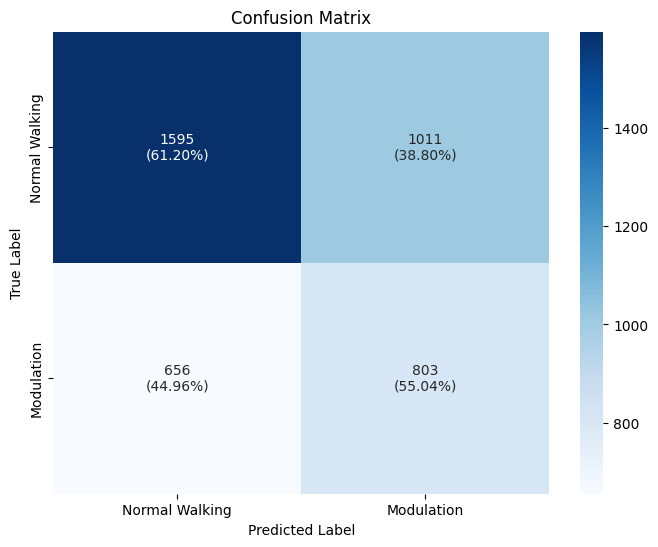

In [7]:
# Plot the confusion matrix with normalized values
plt.figure(figsize=(8, 6))
norm_conf_matrix = overall_confusion_matrix.astype('float') / overall_confusion_matrix.sum(axis=1)[:, np.newaxis]
annot = np.empty_like(overall_confusion_matrix).astype(str)

for i in range(overall_confusion_matrix.shape[0]):
    for j in range(overall_confusion_matrix.shape[1]):
        c = overall_confusion_matrix[i, j]
        n = norm_conf_matrix[i, j]
        annot[i, j] = f'{c}\n({n:.2%})'

sns.heatmap(overall_confusion_matrix, annot=annot, fmt='', cmap='Blues', xticklabels=['Normal Walking', 'Modulation'], yticklabels=['Normal Walking', 'Modulation'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(model_dir, 'confusion_matrix.png'))
plt.show()


In [30]:
# import tensorflow as tf
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# # Define a function to create the Keras model
# def create_keras_model():
#     return best_model

# # Wrap the Keras model in a scikit-learn compatible wrapper
# wrapped_model = KerasClassifier(build_fn=create_keras_model, epochs=10, batch_size=128, verbose=0)

# # Learning Curves: Evaluate if the model is overfitting or underfitting
# train_sizes, train_scores, test_scores = learning_curve(
#     wrapped_model,
#     X_padded,
#     y_padded,
#     groups=groups,
#     cv=logo,
#     scoring='accuracy',
#     n_jobs=-1
# )

# plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
# plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Score')
# plt.xlabel('Training Set Size')
# plt.ylabel('Accuracy')
# plt.title('Learning Curve')
# plt.legend()
# plt.show()

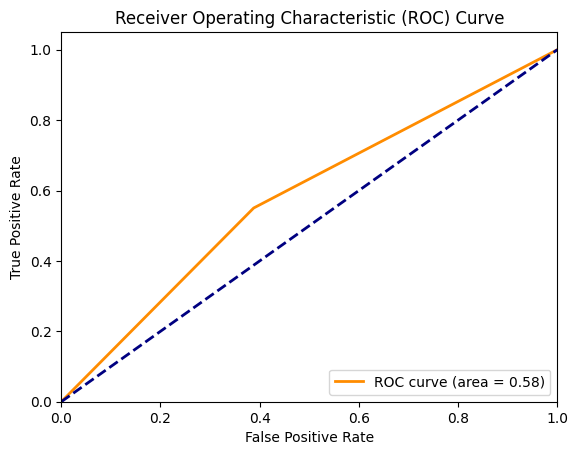

In [8]:
# Plot ROC curve and calculate AUC
fpr, tpr, thresholds = roc_curve(y_true_masked, y_pred_masked)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig(os.path.join(model_dir, 'roc_curve.png'))
plt.show()



In [9]:
# Feature Importance
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    plt.figure(figsize=(8, 6))
    plt.barh(range(len(importances)), importances)
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title('Feature Importances Plot')
    plt.show()

elif hasattr(best_model, 'coef_'):
    importances = best_model.coef_[0]
    plt.figure(figsize=(8, 6))
    plt.barh(range(len(importances)), importances)
    plt.xlabel('Coefficient Value')
    plt.ylabel('Features')
    plt.title('Model Coefficient Plot')
    plt.show()

else:
    print("Model does not support feature importances or coefficients.")


Model does not support feature importances or coefficients.


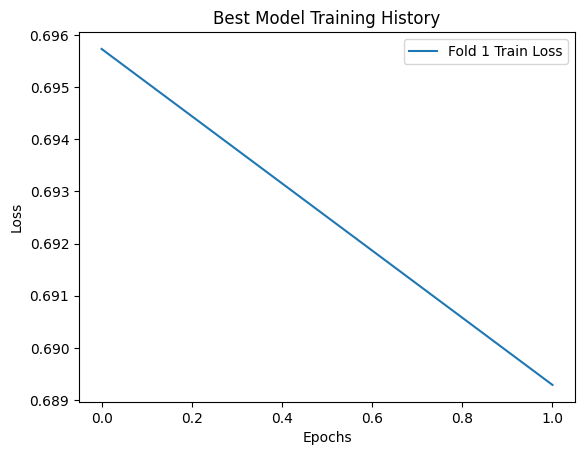

In [11]:
# Load the training history
history_dir = os.path.join("logs", "lstm", "history", f"{ts}")
history_files = [os.path.join(history_dir, f) for f in os.listdir(history_dir) if f.startswith('best_estimator_training_history_')]
history_files.sort()  # Ensure the files are in order

best_history = []
for history_file in history_files:
    with open(history_file, 'r') as f:
        history = json.load(f)
        best_history.append(history)

# Plot the training history
plt.figure()
for fold, history in enumerate(best_history):
    plt.plot(history['loss'], label=f'Fold {fold + 1} Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Best Model Training History')
plt.savefig(os.path.join(model_dir, 'training_history.png'))
plt.show()


In [16]:
# Convert GridSearchCV results into a DataFrame
cv_results_path = os.path.join(model_dir, 'cv_results.csv')
results_df = pd.read_csv(cv_results_path)

# Select relevant columns
# results_df = results_df[
#     [
#         "mean_test_accuracy",  # Mean accuracy across folds
#         "std_test_accuracy",   # Standard deviation of accuracy across folds
#         "mean_test_f1",        # Mean F1 score across folds
#         "std_test_f1",         # Standard deviation of F1 score across folds
#         "mean_test_roc_auc",   # Mean ROC AUC across folds
#         "std_test_roc_auc",    # Standard deviation of ROC AUC across folds
#         "params",              # Hyperparameter combination
#         "rank_test_f1",        # Rank of the F1 score
#     ]
# ]

# Sort by best mean F1 score
# results_df = results_df.sort_values(by="mean_test_f1", ascending=False)

# Extract the scores for each fold
# fold_scores = {}
# for i in range(n_splits):
#     fold_scores[f"fold_{i+1}_accuracy"] = results_df[f"split{i}_test_accuracy"]
#     fold_scores[f"fold_{i+1}_f1"] = results_df[f"split{i}_test_f1"]
#     if f"split{i}_test_roc_auc" in results_df:
#         fold_scores[f"fold_{i+1}_roc_auc"] = results_df[f"split{i}_test_roc_auc"]

# # Convert to DataFrame for better visualization
# fold_scores_df = pd.DataFrame(fold_scores)

# # Display fold scores
# fold_scores_df.T


In [17]:
results_df.T

,0
mean_fit_time,141.355675
std_fit_time,0.051986
mean_score_time,6.460238
std_score_time,1.701022
param_classifier__activations,"['tanh', 'relu']"
param_classifier__batch_size,128
param_classifier__dense_activation,sigmoid
param_classifier__dense_units,120
param_classifier__dropout,0.2
param_classifier__epochs,2
